In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import tensorflow as tf

In [2]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [3]:
import os
path_images = './small_segment/images/'
path_labels = './small_segment/labels/'
imag = os.listdir(path_images)
label = os.listdir(path_labels)

In [4]:
imag, label

(['00_000200.png',
  '00_000400.png',
  '00_000600.png',
  '00_000800.png',
  '00_001000.png',
  '00_001200.png',
  '00_001400.png',
  '00_001600.png',
  '00_001800.png',
  '00_002000.png',
  '00_002200.png',
  '00_002400.png',
  '00_002600.png',
  '00_002800.png',
  '00_003000.png',
  '00_003200.png',
  '00_003400.png'],
 ['00_000200.png',
  '00_000400.png',
  '00_000600.png',
  '00_000800.png',
  '00_001000.png',
  '00_001200.png',
  '00_001400.png',
  '00_001600.png',
  '00_001800.png',
  '00_002000.png',
  '00_002200.png',
  '00_002400.png',
  '00_002600.png',
  '00_002800.png',
  '00_003000.png',
  '00_003200.png',
  '00_003400.png'])

In [5]:
images = []
labels = []
image_size = (256,1024)
for i_name in imag:
    images.append(image.load_img(path_images+i_name, target_size=image_size))
    labels.append(image.load_img(path_labels+i_name, target_size=image_size))

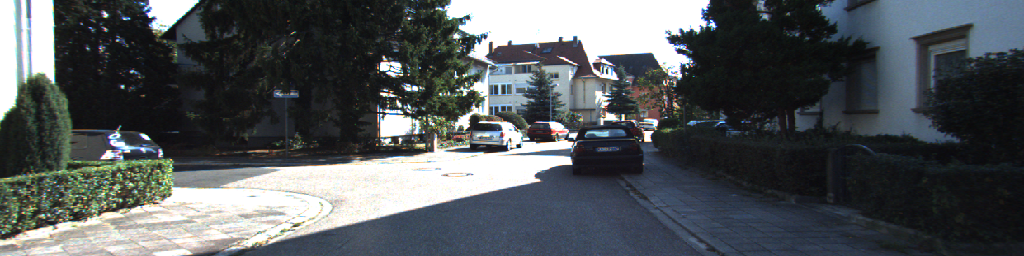

In [62]:
images[0]

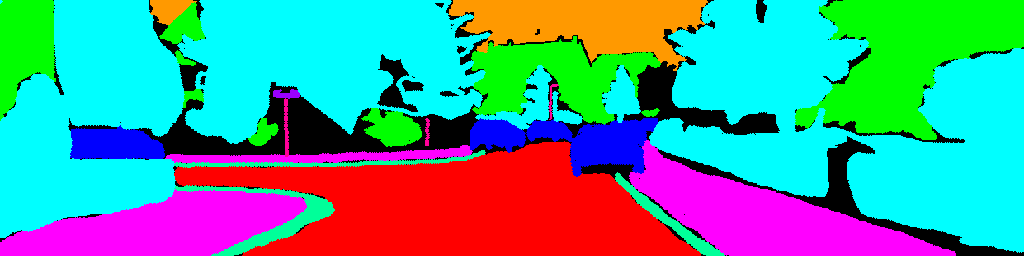

In [63]:
labels[0]

In [6]:
X = []

for i in images:
    x = image.img_to_array(i)
    X.append(x)
    
X = np.array(X)

In [7]:
X.shape

(17, 256, 1024, 3)

In [8]:
np.array(image.img_to_array(labels[0])).shape

(256, 1024, 3)

In [9]:
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1


In [10]:
y = []

for i in labels:
    y_cat, _, _ = Color2index(image.img_to_array(i))
    y.append(y_cat)
y = np.array(y)

In [11]:
y.shape

(17, 256, 1024, 14)

In [12]:
# поделим на тест и трейн
N=10
X_train = X[:N,:,:,:]
y_train = y[:N,:,:,:]

X_test = X[N:,:,:,:]
y_test = y[N:,:,:,:]

In [14]:
from tensorflow.keras.applications import  VGG19

In [15]:
 pre_trained_model_19 = VGG19(input_shape=X.shape[1:], include_top=False, weights="imagenet")

In [16]:
pre_trained_model_19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 1024, 3)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 1024, 64)     1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 1024, 64)     36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 512, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 512, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 512, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 256, 128)      0     

In [17]:
pre_trained_model_19.trainable = False # не будем обучать первую половину слоев

In [18]:
def block_transpose(x, block_out):
    x = tf.keras.layers.Concatenate()([x, block_out])#([x, block_out])
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x



In [41]:
def unet_pre_train(num_classes=14, input_shape = (256, 1024, 3)):
    pre_trained_model_19 = VGG19(input_shape=X.shape[1:], include_top=False, weights="imagenet")
    #for layer in pre_trained_model.layers[:18]:
      #layer.trainable = False
    x = pre_trained_model_19.layers[20].output # последняя свертка
    blockout_1 = pre_trained_model_19.layers[3].output # нужно для конкатенации
    blockout_2 = pre_trained_model_19.layers[6].output
    blockout_3 = pre_trained_model_19.layers[11].output
    blockout_4 = pre_trained_model_19.layers[16].output

    img_input = pre_trained_model_19.inputs 

    x = block_transpose(x, blockout_4) # обратные проходы с увеличением
    x = block_transpose(x, blockout_3)
    x = block_transpose(x, blockout_2)
    x = block_transpose(x, blockout_1)

    x = Conv2D(64, (3, 3), padding='same')(x) #один слой полносвязной сети
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(14, (3, 3), activation='softmax', padding='same')(x) # выходной слой

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

In [42]:
model_19 = unet_pre_train(num_classes=14, input_shape = (256, 1024, 3))


In [154]:
model_19.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 256, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 1024, 6  1792        ['input_19[0][0]']               
                                4)                                                                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 1024, 6  36928       ['block1_conv1[0][0]']           
                                4)                                                          

                                                                                                  
 activation_34 (Activation)     (None, 32, 128, 128  0           ['batch_normalization_34[0][0]'] 
                                )                                                                 
                                                                                                  
 concatenate_27 (Concatenate)   (None, 32, 128, 384  0           ['activation_34[0][0]',          
                                )                                 'block3_pool[0][0]']            
                                                                                                  
 conv2d_19 (Conv2D)             (None, 32, 128, 128  442496      ['concatenate_27[0][0]']         
                                )                                                                 
                                                                                                  
 batch_nor

                                8)                                                                
                                                                                                  
 conv2d_transpose_10 (Conv2DTra  (None, 256, 1024, 1  65664      ['activation_42[0][0]']          
 nspose)                        28)                                                               
                                                                                                  
 batch_normalization_43 (BatchN  (None, 256, 1024, 1  512        ['conv2d_transpose_10[0][0]']    
 ormalization)                  28)                                                               
                                                                                                  
 activation_43 (Activation)     (None, 256, 1024, 1  0           ['batch_normalization_43[0][0]'] 
                                28)                                                               
          

In [43]:
model_19.fit(X_train, y_train, epochs=40, batch_size=2, validation_data=(X_test, y_test))

Epoch 1/40
5/5 [==============================] - 9s 774ms/step - loss: 2.2960 - dice_coef: 0.1652 - val_loss: 2.7615 - val_dice_coef: 0.1883
Epoch 2/40
5/5 [==============================] - 3s 674ms/step - loss: 1.5692 - dice_coef: 0.3387 - val_loss: 4.0929 - val_dice_coef: 0.1115
Epoch 3/40
5/5 [==============================] - 3s 635ms/step - loss: 1.3925 - dice_coef: 0.4006 - val_loss: 3.5061 - val_dice_coef: 0.1474
Epoch 4/40
5/5 [==============================] - 3s 620ms/step - loss: 1.2532 - dice_coef: 0.4234 - val_loss: 3.1556 - val_dice_coef: 0.1717
Epoch 5/40
5/5 [==============================] - 3s 622ms/step - loss: 1.2002 - dice_coef: 0.4619 - val_loss: 2.8284 - val_dice_coef: 0.1896
Epoch 6/40
5/5 [==============================] - 3s 623ms/step - loss: 1.1601 - dice_coef: 0.4848 - val_loss: 2.5696 - val_dice_coef: 0.2110
Epoch 7/40
5/5 [==============================] - 3s 642ms/step - loss: 1.1197 - dice_coef: 0.4919 - val_loss: 2.7028 - val_dice_coef: 0.2004
Epoch 

In [30]:
def unet_pre_train_512(num_classes=14, input_shape = (256, 1024, 3)):
    pre_trained_model_19 = VGG19(input_shape=X.shape[1:], include_top=False, weights="imagenet")
    #for layer in pre_trained_model.layers[:18]:
      #layer.trainable = False
    x = pre_trained_model_19.layers[20].output # последняя свертка
    blockout_1 = pre_trained_model_19.layers[3].output # нужно для конкатенации
    blockout_2 = pre_trained_model_19.layers[6].output
    blockout_3 = pre_trained_model_19.layers[11].output
    blockout_4 = pre_trained_model_19.layers[16].output

    img_input = pre_trained_model_19.inputs 

    x = block_transpose(x, blockout_4) # обратные проходы с увеличением
    x = block_transpose(x, blockout_3)
    x = block_transpose(x, blockout_2)
    x = block_transpose(x, blockout_1)

    x = Conv2D(512, (3, 3), padding='same')(x) #один слой полносвязной сети
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(14, (3, 3), activation='softmax', padding='same')(x) # выходной слой

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

In [31]:
model_19_512 = unet_pre_train_512(num_classes=14, input_shape = (256, 1024, 3))

In [32]:
model_19_512.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 1024,   0           []                               
                                3)]                                                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 1024, 6  1792        ['input_4[0][0]']                
                                4)                                                                
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 1024, 6  36928       ['block1_conv1[0][0]']           
                                4)                                                          

                                                                                                  
 activation_28 (Activation)     (None, 32, 128, 128  0           ['batch_normalization_28[0][0]'] 
                                )                                                                 
                                                                                                  
 concatenate_9 (Concatenate)    (None, 32, 128, 384  0           ['activation_28[0][0]',          
                                )                                 'block3_pool[0][0]']            
                                                                                                  
 conv2d_22 (Conv2D)             (None, 32, 128, 128  442496      ['concatenate_9[0][0]']          
                                )                                                                 
                                                                                                  
 batch_nor

                                8)                                                                
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 256, 1024, 1  65664      ['activation_36[0][0]']          
 nspose)                        28)                                                               
                                                                                                  
 batch_normalization_37 (BatchN  (None, 256, 1024, 1  512        ['conv2d_transpose_11[0][0]']    
 ormalization)                  28)                                                               
                                                                                                  
 activation_37 (Activation)     (None, 256, 1024, 1  0           ['batch_normalization_37[0][0]'] 
                                28)                                                               
          

In [33]:
model_19_512.fit(X_train, y_train, epochs=40, batch_size=2, validation_data=(X_test, y_test))

Epoch 1/40
5/5 [==============================] - 94s 2s/step - loss: 2.5523 - dice_coef: 0.2680 - val_loss: 4.5690 - val_dice_coef: 0.0953
Epoch 2/40
5/5 [==============================] - 5s 1s/step - loss: 1.8828 - dice_coef: 0.3352 - val_loss: 3.6139 - val_dice_coef: 0.2492
Epoch 3/40
5/5 [==============================] - 5s 1s/step - loss: 1.5405 - dice_coef: 0.3836 - val_loss: 2.9283 - val_dice_coef: 0.2403
Epoch 4/40
5/5 [==============================] - 5s 1s/step - loss: 1.3452 - dice_coef: 0.4437 - val_loss: 3.0660 - val_dice_coef: 0.1893
Epoch 5/40
5/5 [==============================] - 5s 1s/step - loss: 1.2856 - dice_coef: 0.4533 - val_loss: 2.6230 - val_dice_coef: 0.2002
Epoch 6/40
5/5 [==============================] - 6s 1s/step - loss: 1.1721 - dice_coef: 0.4675 - val_loss: 2.5526 - val_dice_coef: 0.1860
Epoch 7/40
5/5 [==============================] - 5s 1s/step - loss: 1.1496 - dice_coef: 0.4896 - val_loss: 2.5269 - val_dice_coef: 0.1797
Epoch 8/40
5/5 [==========

In [34]:
model_19_512.evaluate(X_test, y_test)

1/1 [==============================] - 11s 11s/step - loss: 1.4757 - dice_coef: 0.4840


[1.4756934642791748, 0.48402878642082214]

In [44]:
model_19.evaluate(X_test, y_test)

1/1 [==============================] - 1s 887ms/step - loss: 1.3324 - dice_coef: 0.4915


[1.332355260848999, 0.4914979934692383]